# Домашняя работа 1


## Описание

В этой домашней работе вы должны применить знания по многослойным нейроным сетям

- Для простоты попробуем обучить сначала однослойный перцептрон
- Решать будем простую задачу бинарной классификации
- Датасет игрушечный -  `load_data()` загружает его


In [141]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## Загрузка данных

In [142]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [143]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


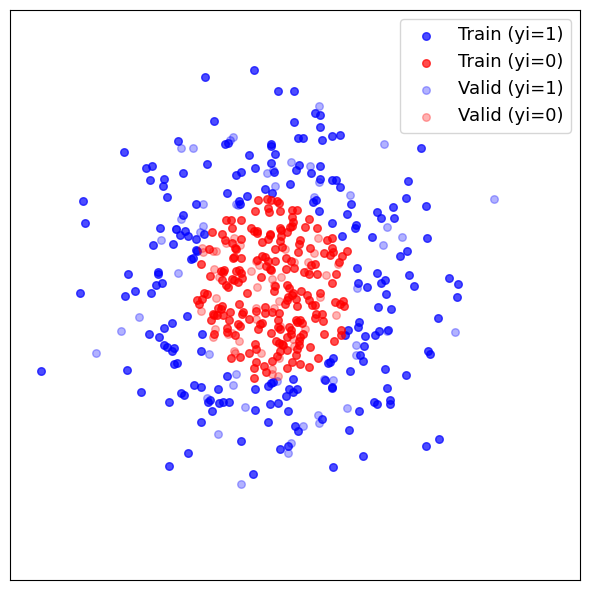

In [144]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## Класс нейросети

Вам необходимо описать простую полносвязную многослойную нейронную сеть

In [145]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, output_size=1):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.model(X)

##  Функция обучения сети

Необходимо сохранять историю лоссов для последующего сравнения и визуализации.
Также нужно реализовать early stopping. Критерий остановки подбирите на ваше усмотрение.

In [146]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=1000, patience=10):
    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience_counter = 0

    if isinstance(criterion, nn.BCELoss):
        X_train_copy = X_train.clone().detach()
        X_val_copy = X_val.clone().detach()
        y_train_copy = y_train.clone().detach()
        y_val_copy = y_val.clone().detach()
        # X_train_copy = torch.tensor(X_train, dtype=torch.float32)
        # X_val_copy = torch.tensor(X_val, dtype=torch.float32)
        # y_train_copy = torch.tensor(y_train, dtype=torch.float32)
        # y_val_copy = torch.tensor(y_val, dtype=torch.float32)
    else:
        X_train_copy = X_train
        X_val_copy = X_val
        y_train_copy = y_train.long()
        y_val_copy = y_val.long()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_copy)
        loss = criterion(outputs.squeeze(), y_train_copy)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_copy)
            val_loss = criterion(val_outputs.squeeze(), y_val_copy)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if val_loss.item() < best_loss:
            best_loss = val_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return train_losses, val_losses

### Обучите сеть

Обучите сеть три раза - с тремя разными оптимизиторами
Не забудьте переинициализировать сеть заного перед каждой загрузкой. Убедитесь, что вы верно передали параметры сети в оптимизатор

**Подсказка** Лучше объявить три независимых объекта - модель1, модель2 и модель3

In [147]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

models = [NeuralNetwork() for _ in range(3)]

optimizers = [torch.optim.SGD(models[0].parameters(), lr=0.01),
              torch.optim.Adam(models[1].parameters(), lr=0.01),
              torch.optim.RMSprop(models[2].parameters(), lr=0.01)]

criterion = nn.BCELoss()

losses = []

for i in range(3):
    print(f"Training model {i+1} with {optimizers[i].__class__.__name__}")
    losses.append(train_model(models[i], criterion, optimizers[i],
                            X_train_torch, y_train_torch, X_valid_torch, y_valid_torch))

Training model 1 with SGD
Training model 2 with Adam
Training model 3 with RMSprop


### А теперь посмотрим на графики лоссов

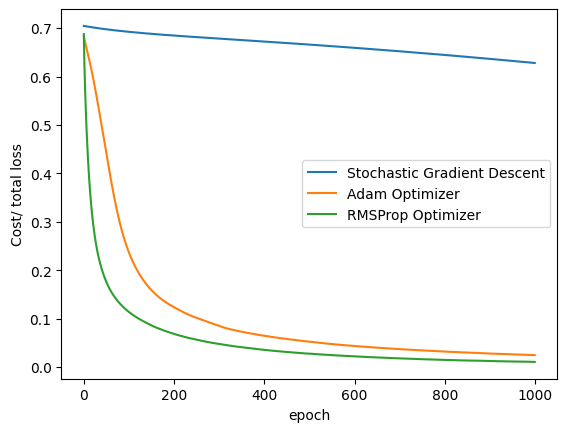

In [148]:
# Смотрим лоссы на трейне
plt.plot(range(len(losses[0][0])), losses[0][0], label = "Stochastic Gradient Descent")
plt.plot(range(len(losses[1][0])), losses[1][0], label = "Adam Optimizer")
plt.plot(range(len(losses[2][0])), losses[2][0], label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

### Инициализация

Теперь проинициализируйте веса в вашей модели: случайно и Ксавьером. Сравните эти две модели на предыдущей задаче.

In [149]:
class RandomNetwork(NeuralNetwork):
    def __init__(self, input_size=2, hidden_size=10, output_size=1):
        super(RandomNetwork, self).__init__(input_size, hidden_size, output_size)
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                layer.weight.data.uniform_(-1, 1)
                layer.bias.data.uniform_(-1, 1)


class XavierNetwork(NeuralNetwork):
    def __init__(self, input_size=2, hidden_size=10, output_size=1):
        super(XavierNetwork, self).__init__(input_size, hidden_size, output_size)
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

In [150]:
models = [RandomNetwork(), XavierNetwork()]

optimizers = [torch.optim.Adam(models[0].parameters(), lr=0.01),
              torch.optim.Adam(models[1].parameters(), lr=0.01)]

criterion = nn.BCELoss()

losses = []

for i in range(2):
    print(f"Training model {i+1} with {optimizers[i].__class__.__name__}")
    losses.append(train_model(models[i], criterion, optimizers[i],
                            X_train_torch, y_train_torch, X_valid_torch, y_valid_torch))

Training model 1 with Adam
Training model 2 with Adam


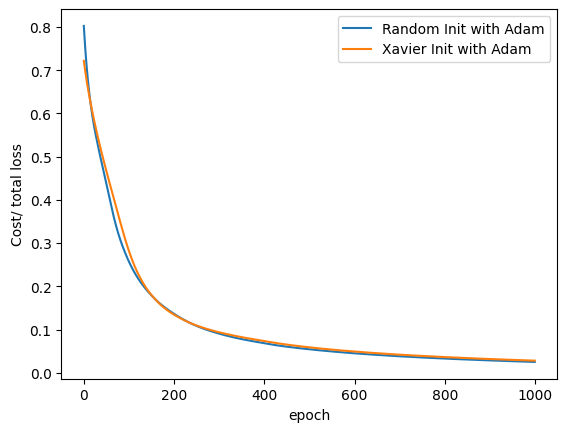

In [151]:
# Смотрим лоссы на трейне
plt.plot(range(len(losses[0][0])), losses[0][0], label = "Random Init with Adam")
plt.plot(range(len(losses[1][0])), losses[1][0], label = "Xavier Init with Adam")
plt.xlabel('epoch')
plt.ylabel('Cost/ total loss')
plt.legend()
plt.show()

В данном примере разница не очень видна.

## А теперь решите многоклассовую проблему

Продемонстрируйте свои знания - решите более сложную проблему.
Попробуйте разные инициализации, методы оптимизации и кол-во нейронов.

**Найдите лучшие параметры через KFold**

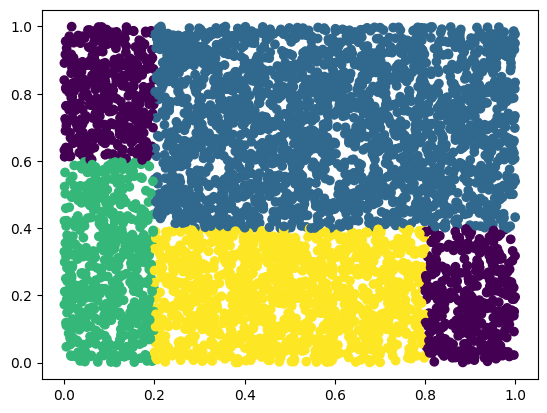

In [152]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [153]:
X = data[:, :2]
y = data[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [154]:
class AdvancedModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=20, output_size=4, init_type='xavier'):
        super(AdvancedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        # self.softmax = nn.Softmax(dim=1)  # accuracy is worse with softmax

        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        else:
            self.fc1.weight.data.uniform_(-1, 1)
            self.fc2.weight.data.uniform_(-1, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold


def train_model_CV(X, y, hidden_size=20, init_type='xavier', optimizer_type='adam',
                   epochs=1000, input_size=2, output_size=4):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    losses = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = AdvancedModel(input_size=input_size, hidden_size=hidden_size, init_type=init_type, output_size=output_size)
        criterion = nn.CrossEntropyLoss()

        if optimizer_type == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        elif optimizer_type == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train.long())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.long())
            losses.append(val_loss.item())

    return np.mean(losses)

In [156]:
best_params = None
best_loss = float('inf')

for hidden_size in [10, 20, 50]:
    for init in ['xavier', 'random']:
        for opt in ['adam', 'sgd', 'rmsprop']:
            loss = train_model_CV(X_train, y_train, hidden_size, init, opt)
            print(f"Hidden: {hidden_size}, Init: {init}, Opt: {opt},\tLoss: {loss:.4f}")
            if loss < best_loss:
                best_loss = loss
                best_params = (hidden_size, init, opt)
    print()

print("Best parameters:", best_params)

Hidden: 10, Init: xavier, Opt: adam,	Loss: 0.0950
Hidden: 10, Init: xavier, Opt: sgd,	Loss: 0.9989
Hidden: 10, Init: xavier, Opt: rmsprop,	Loss: 0.0784
Hidden: 10, Init: random, Opt: adam,	Loss: 0.0934
Hidden: 10, Init: random, Opt: sgd,	Loss: 0.9073
Hidden: 10, Init: random, Opt: rmsprop,	Loss: 0.0708

Hidden: 20, Init: xavier, Opt: adam,	Loss: 0.0715
Hidden: 20, Init: xavier, Opt: sgd,	Loss: 0.9737
Hidden: 20, Init: xavier, Opt: rmsprop,	Loss: 0.0676
Hidden: 20, Init: random, Opt: adam,	Loss: 0.0682
Hidden: 20, Init: random, Opt: sgd,	Loss: 0.8478
Hidden: 20, Init: random, Opt: rmsprop,	Loss: 0.0585

Hidden: 50, Init: xavier, Opt: adam,	Loss: 0.0582
Hidden: 50, Init: xavier, Opt: sgd,	Loss: 0.9024
Hidden: 50, Init: xavier, Opt: rmsprop,	Loss: 0.0610
Hidden: 50, Init: random, Opt: adam,	Loss: 0.0524
Hidden: 50, Init: random, Opt: sgd,	Loss: 0.6317
Hidden: 50, Init: random, Opt: rmsprop,	Loss: 0.0546

Best parameters: (50, 'random', 'adam')


In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

model = AdvancedModel(hidden_size=50, init_type='random')
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=0.01),
            X_train, y_train, X_valid, y_valid)

model.eval()
y_pred = model(X_test)
predictions = torch.argmax(y_pred, dim=1)
accuracy = (predictions == y_test.long()).float().mean().item()
print(f"Best Model's accuracy = {accuracy:.2f}")

Best Model's accuracy = 0.98


## (Почти) Боевая задача

Перед вами датасет с классификацией алкоголя. Продемонстрируйте свои знания и решите задачу многоклассовой классификации

In [158]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [166]:
X = df.drop(columns=['target']).values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [167]:
best_params = None
best_loss = float('inf')

for hidden_size in [10, 20, 50]:
    for init in ['xavier', 'random']:
        for opt in ['adam', 'sgd', 'rmsprop']:
            loss = train_model_CV(X_train, y_train, hidden_size, init, opt,
                                  input_size=X_train.shape[1], output_size=df["target"].nunique())
            print(f"Hidden: {hidden_size}, Init: {init}, Opt: {opt},\tLoss: {loss:.4f}")
            if loss < best_loss:
                best_loss = loss
                best_params = (hidden_size, init, opt)
    print()

print("Best parameters:", best_params)

Hidden: 10, Init: xavier, Opt: adam,	Loss: 0.1121
Hidden: 10, Init: xavier, Opt: sgd,	Loss: 0.0873
Hidden: 10, Init: xavier, Opt: rmsprop,	Loss: 0.1185
Hidden: 10, Init: random, Opt: adam,	Loss: 0.0463
Hidden: 10, Init: random, Opt: sgd,	Loss: 0.0945
Hidden: 10, Init: random, Opt: rmsprop,	Loss: 0.1108

Hidden: 20, Init: xavier, Opt: adam,	Loss: 0.0684
Hidden: 20, Init: xavier, Opt: sgd,	Loss: 0.0931
Hidden: 20, Init: xavier, Opt: rmsprop,	Loss: 0.1570
Hidden: 20, Init: random, Opt: adam,	Loss: 0.0831
Hidden: 20, Init: random, Opt: sgd,	Loss: 0.1236
Hidden: 20, Init: random, Opt: rmsprop,	Loss: 0.2030

Hidden: 50, Init: xavier, Opt: adam,	Loss: 0.0564
Hidden: 50, Init: xavier, Opt: sgd,	Loss: 0.0897
Hidden: 50, Init: xavier, Opt: rmsprop,	Loss: 0.0958
Hidden: 50, Init: random, Opt: adam,	Loss: 0.1670
Hidden: 50, Init: random, Opt: sgd,	Loss: 0.1184
Hidden: 50, Init: random, Opt: rmsprop,	Loss: 0.0386

Best parameters: (50, 'random', 'rmsprop')


In [168]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

model = AdvancedModel(input_size=X_train.shape[1], hidden_size=20,
                      output_size=df["target"].nunique(), init_type='xavier')
train_model(model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=0.01),
            X_train, y_train, X_valid, y_valid)

model.eval()
y_pred = model(X_test)
predictions = torch.argmax(y_pred, dim=1)
accuracy = (predictions == y_test.long()).float().mean().item()
print(f"Best Model's accuracy = {accuracy:.2f}")
# accuracy without scaling is approximately 0.89

Early stopping at epoch 146
Best Model's accuracy = 1.00
